# Fake News Identification: Machine Learning and Deep Learning Approaches.

In this project, I aim to differentiate between dirty and clean plates using machine learning. The dataset, sourced from a Kaggle competition. 
<br>I will utilize transfer learning to leverage pre-trained models, enhancing classification accuracy. 
<br>After training, I will implement an active learning approach, where I will select samples with the highest likelihood predictions from 
<br>an unlabeled dataset. These selected samples will then be labeled and added to the training set, allowing me to iteratively improve the model. 
<br>Ultimately, I will submit the predictions on the Kaggle platform and apply the trained model to my own images of plates to assess 
<br>its performance in real photos by uploading here.

<br> Data set is provided form [`Kaggle Breast Ultrasound Images Dataset(BUSI)`](https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset)

## Outline
- [ 1 - Import Data](#1)
- [ 2 - ML models](#2)
  - [ 2.1 - SVM](#2.1)
  - [ 2.2 - Naive Bayes](#2.2)
  - [ 2.3 - Logistic Regression](#2.3)
- [ 3 - Neuron networks](#3)
  - [ 3.1 - Convolutional NN](#3.1)
  - [ 3.2 - LSTM](#3.2)
  - [ 3.3 - Bidirectional LSTM](#3.3)
- [ 4 - Fine-Tuning (DistilBert)](#4)

<a name="1"></a>
## 1 - Import Data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from IPython.display import display
from IPython.display import Image as image
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os,glob, re
from PIL import Image
import pandas as pd
import random
import shutil
import cv2
from ipywidgets import widgets
from io import BytesIO

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set memory growth BEFORE initializing any TensorFlow operations
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
        print(f"Memory growth enabled for {device}")
    except RuntimeError as e:
        # Memory growth must be set before TensorFlow operations are initialized
        print(f"Error enabling memory growth for {device}: {e}")

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
seed = 42
tf.random.set_seed(seed)

In [3]:
class_names_step_one = ["normal", "cancer"]
train_path_stage_one = "/Users/sergeiakhmadulin/Documents/Braest Censer/Two steps/First_step/train"
val_path_stage_one = "/Users/sergeiakhmadulin/Documents/Braest Censer/Two steps/First_step/val"

target_size=(256, 256)

In [174]:
def count_and_plot_files(path, class_names, stage=1):
    count_files = {}

    for class_name in class_names:
        if stage == 1:
            path_orig_name = os.path.join(path, class_name)
            files = os.listdir(path_orig_name)
        else:
            path_orig_name = os.path.join(path, 'images')
            files = os.listdir(path_orig_name)
            files = [f for f in files if f.endswith('.png') and '_mask' not in f and class_name in f]
        
        count_files[class_name] = len(files)

    # Extract labels and values
    labels = list(count_files.keys())
    values = list(count_files.values())

    # Create the histogram (bar plot)
    bars = plt.bar(labels, values)

    # Adding title and labels
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Annotate each bar with its exact value
    for bar in bars:
        yval = bar.get_height()  # Height of each bar (which is the value)
        plt.text(bar.get_x() + bar.get_width() / 2, yval, str(yval), ha='center', va='bottom', fontsize=10)

    # Display the plot
    plt.show()

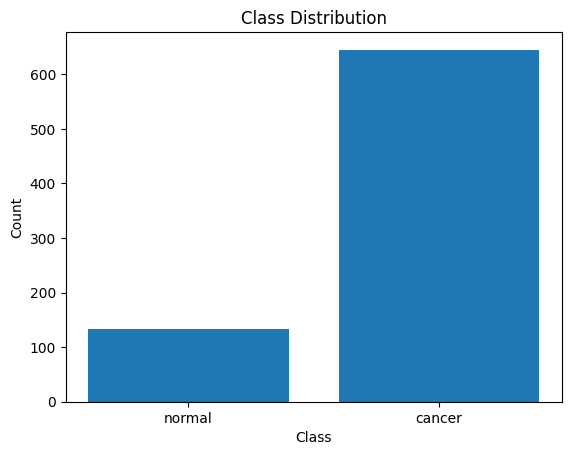

In [44]:
count_and_plot_files(train_path_stage_one, class_names_step_one)

In [45]:
##AUGMENTATION

class SegmentationTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image, mask = False):
        # Apply the same transformation to both image and mask
        seed = np.random.randint(0, 2**32)  # Random seed to ensure the same transformations are applied
        torch.manual_seed(seed)
        transformed_image = self.transform(image)

        # To apply the same transformation to the mask, we need to modify the mask tensor as well.
        if mask:
            torch.manual_seed(seed)
            transformed_mask = self.transform(mask)
            
            return transformed_image, transformed_mask
            
        return transformed_image

# Augmentation transformations (for oversampling)
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])

seg_transform = SegmentationTransform(augmentation)

In [46]:
def augment_images(path_orig, class_name, desire_num_images, mask = False):
    path = os.path.join(path_orig, class_name)
    files = os.listdir(path)
    orig_files = [file for file in files if '_mask' not in os.path.basename(file) and '.DS_Store' not in files]   
    if mask:
        masked_files = [file for file in files if '_mask' in os.path.basename(file) and '.DS_Store' not in files]
        
    aug_each = (desire_num_images - len(orig_files))//len(orig_files) + 1

    for file in tqdm(orig_files, desc="Processing files", unit="file"):
        for num in range(aug_each):
            image_path = os.path.join(path, file)
            image = Image.open(image_path)
            

            if mask:
                file_mask = file.split(".")[0] + "_mask.png"
                mask_path = os.path.join(path, file_mask)
                mask = Image.open(mask_path)
                # Apply augmentation
                augmented_image, augmented_mask = seg_transform(image, mask)
                to_pil = transforms.ToPILImage()
                augmented_img_pil = to_pil(augmented_image)
                augmented_mask_pil = to_pil(augmented_mask)

                augmented_mask_numpy = augmented_mask.numpy().transpose(1, 2, 0)

                augmented_image_filename = file.split(".")[0] + "_aug_" + str(num) + ".png"
                augmented_mask_filename = file.split(".")[0] + "_aug_" + str(num) + "_mask.png"
        
                augmented_img_pil.save(os.path.join(path, augmented_image_filename))
                augmented_mask_pil.save(os.path.join(path, augmented_mask_filename))

            else:
                
                augmented_image = seg_transform(image)
                to_pil = transforms.ToPILImage()
                augmented_img_pil = to_pil(augmented_image)
                augmented_image_filename = file.split(".")[0] + "_aug_" + str(num) + ".png"
                augmented_img_pil.save(os.path.join(path, augmented_image_filename))
            

In [47]:
augment_images(train_path_stage_one, "normal", desire_num_images = 650)

4



rocessing files: 100%|█████████████████████| 133/133 [01:14<00:00,  1.78file/s]

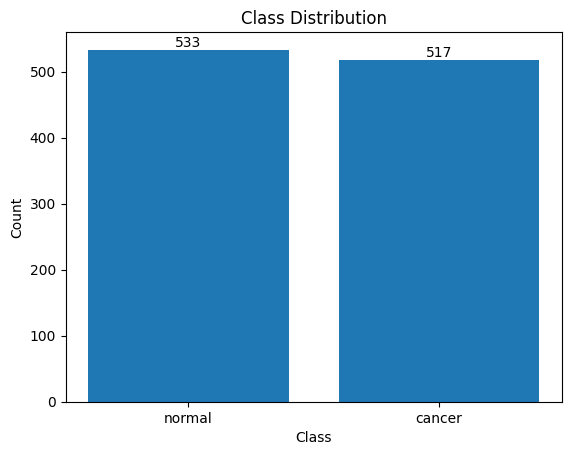

In [176]:
count_and_plot_files(train_path_stage_one, class_names_step_one , stage = 1)

In [86]:
# Function for splitting dataset

def create_folders(base_dir, new_dir, class_names, subsets=['train', 'val'], mask = False):
    """
    Creates necessary folder structure: Class/{images, masks}
    """
    for subset in subsets:
        for class_name in class_names:
            # Create class folder for subset (train/val)
            class_folder = os.path.join(new_dir, subset, class_name)
            
            if mask:
                os.makedirs(os.path.join(class_folder, 'images'), exist_ok=True)
                os.makedirs(os.path.join(class_folder, 'masks'), exist_ok=True)
            else:
                os.makedirs(class_folder, exist_ok=True)
    print(f"Folders created")

def split_dataset(image_dir, new_dir, class_names, train_ratio=0.8, mask = False, mask_dir = False):
    """
    Split the dataset into train and val sets for each class.
    """

    for class_name in class_names:
        # Get list of all image and mask filenames
        image_files = [f for f in os.listdir(os.path.join(image_dir, class_name)) if f.endswith('.png') and '_mask' not in f]
        if mask:
            mask_files = [f for f in os.listdir(os.path.join(image_dir, class_name)) if f.endswith('.png') and '_mask' in f]
        # Split into training and validation sets
        train_count = int(len(image_files) * train_ratio)
        train_images = image_files[:train_count]
        val_images = image_files[train_count:]

        # Move files to train and val folders
        for num, image_file in enumerate(val_images):
            if mask:
                mask_file = image_file.split(".")[0] + "_mask.png"
                mask_path = os.path.join(image_dir, class_name, mask_file)
                image_path = os.path.join(image_dir, class_name, image_file)
                shutil.move(image_path, os.path.join(new_dir, "val", class_name, 'images', image_file))
                shutil.move(mask_path, os.path.join(new_dir, "val", class_name, 'masks', mask_file))
            else:
                image_path = os.path.join(image_dir, class_name, image_file)
                shutil.move(image_path, os.path.join(new_dir, class_name, image_file))
                
                
    print("Splitting finished")


In [57]:
create_folders(train_path_stage_one, val_path_stage_one, class_names_step_one, subsets=['train', 'val'])

Folders created


In [87]:

# Split dataset into train/val and move images/masks
split_dataset(train_path_stage_one, val_path_stage_one, class_names_step_one, train_ratio=0.8)

Splitting finished


In [89]:
def train_val_datasets(train_path, test_path):
    """
    Creates datasets for training and validation.
    
    Parameters:
    train_path: directory of training folder
    val_path: directory of validation folder
    
    Returns:
    (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=train_path,
        batch_size=10,
        image_size=target_size,
        shuffle=True,
        seed=seed
    )
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=test_path,
        batch_size=10,
        image_size=target_size,
        shuffle=True,
        seed=seed
    )

    return training_dataset, validation_dataset

In [99]:
def create_pre_trained_model():
    """
    Creates the pretrained EfficientNetB0 model

    Returns:
    tf.keras.Model: pre-trained model
    
    """
    
    pre_trained_model = tf.keras.applications.EfficientNetB0(
        include_top=False,  # Remove the fully connected layer
        input_shape=target_size + (3,),
        weights='imagenet'  # Use pre-trained weights
    )
    pre_trained_model.trainable = False  # Freeze the base model

    return pre_trained_model

In [100]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    """
    Class of callback that contains cases for stopping model training

    patience: number of epoch to wait until improvement in test accuracy
    """
    def __init__(self, patience=5):
        super(EarlyStoppingCallback, self).__init__()
        self.patience = patience
        self.best_accuracy = 0.0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        
        if current_accuracy is None:
            return
        
        if current_accuracy - self.best_accuracy >= 0.03: # differense in current test accuracy and best grather or equals to 3% 
            self.best_accuracy = current_accuracy
            self.wait = 0
            print(f"New best accuracy: {self.best_accuracy:.4f}")
        else:
            self.wait += 1
            print(f"No improvement in epoch {epoch + 1}. Waiting {self.wait}/{self.patience}...")

        if self.wait >= self.patience:
            print("Early stopping triggered!")
            self.model.stop_training = True

        if logs['accuracy'] >= 0.99 and logs['val_accuracy'] >= 0.99: # earlystopping
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

In [101]:
checkpoint = ModelCheckpoint(
    'best_model_EfficientNetB0_base_0.keras',               # File name to save the model
    monitor='val_accuracy',         # Metric to monitor
    save_best_only=True,           # Save only the best model
    mode='max',                    # Mode (max for accuracy)
    verbose=1                      # Verbosity
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',       # Metric to monitor
    factor=0.2,               # Factor by which the learning rate will be reduced
    patience=2,               # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,              # Minimum learning rate
    verbose=1
)

In [103]:
seed = 42

# Load datasets
training_dataset, validation_dataset = train_val_datasets(train_path_stage_one, val_path_stage_one)

# Create base model
base_model = create_pre_trained_model()

Found 1048 files belonging to 2 classes.


2025-01-19 21:26:27.436953: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-19 21:26:27.438257: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-19 21:26:27.438562: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-19 21:26:27.439030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-19 21:26:27.440030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 262 files belonging to 2 classes.


In [104]:
def run_training(model, training_dataset, validation_dataset, danse_neurons, dropout, learning_rate, epochs, patience, filename, verbose):


        # Create the ModelCheckpoint callback with the dynamic filename
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filename,  # Dynamic filename with timestamp and validation accuracy placeholder
        monitor='val_accuracy',  # Metric to monitor
        save_best_only=True,     # Save only the best model
        mode='max',              # Mode (max for accuracy)
        verbose=verbose                # Verbosity
    )

        # EarlyStopping callback
    early_stopping = EarlyStoppingCallback(patience=patience)

        # ReduceLROnPlateau callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=verbose
    )
    
    # Train the model
    history = model.fit(
        training_dataset,
        validation_data = validation_dataset,
        epochs = epochs,
        verbose = verbose,
        callbacks = [EarlyStoppingCallback(patience=patience),checkpoint,reduce_lr],
    )
    return model, history

In [105]:
model = models.Sequential([
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')  # For binary classification
    ])
    
    # Compile the model with sparse_categorical_crossentropy for integer-encoded labels
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [149]:
model_trained, history = run_training(model,training_dataset, validation_dataset, danse_neurons = 1024,dropout = 0.1
                                      ,learning_rate = 0.001,epochs = 5, patience = 5, filename = 'model_to_allocate_cancer.keras',verbose = 1)

Epoch 1/5
New best accuracy: 0.9313

Epoch 1: val_accuracy improved from -inf to 0.93130, saving model to model_to_allocate_cancer.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 231ms/step - accuracy: 0.8862 - loss: 0.2413 - val_accuracy: 0.9313 - val_loss: 0.1460 - learning_rate: 0.0010
Epoch 2/5
No improvement in epoch 2. Waiting 1/5...

Epoch 2: val_accuracy improved from 0.93130 to 0.95802, saving model to model_to_allocate_cancer.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - accuracy: 0.8890 - loss: 0.2589 - val_accuracy: 0.9580 - val_loss: 0.1456 - learning_rate: 0.0010
Epoch 3/5
No improvement in epoch 3. Waiting 2/5...

Epoch 3: val_accuracy did not improve from 0.95802
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - accuracy: 0.8890 - loss: 0.2689 - val_accuracy: 0.9160 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 4/5
No improvement in epoch 4. Waiting 3/5...

Epoch 4: val_accuracy did not improve from 0.95802

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000

In [152]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = models.Sequential([
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')  # For binary classification
    ])
    
    # Compile the model with sparse_categorical_crossentropy for integer-encoded labels
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [153]:
model_trained, history = run_training(model,training_dataset, validation_dataset, danse_neurons = 1024,dropout = 0.1
                                      ,learning_rate = 0.001,epochs = 5, patience = 5, filename = 'model_to_allocate_cancer.keras',verbose = 1)

Epoch 1/5
New best accuracy: 0.9580

Epoch 1: val_accuracy improved from -inf to 0.95802, saving model to model_to_allocate_cancer.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 91s 601ms/step - accuracy: 0.7396 - loss: 0.6220 - val_accuracy: 0.9580 - val_loss: 0.1285 - learning_rate: 0.0010
Epoch 2/5
No improvement in epoch 2. Waiting 1/5...

Epoch 2: val_accuracy did not improve from 0.95802
105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 505ms/step - accuracy: 0.8811 - loss: 0.2933 - val_accuracy: 0.9580 - val_loss: 0.1321 - learning_rate: 0.0010
Epoch 3/5
No improvement in epoch 3. Waiting 2/5...

Epoch 3: val_accuracy did not improve from 0.95802

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 536ms/step - accuracy: 0.9115 - loss: 0.2139 - val_accuracy: 0.9427 - val_loss: 0.1240 - learning_rate: 0.0010
Epoch 4/5
No improvement in epoch 4. Waiting 3/5...

Epoch 4: val_accuracy improved from 0.95802 to 0.97328, saving model to model_to_allocate_ca

In [154]:
all_labels = []
pred = []
for images, labels in validation_dataset:
    # Collect the labels from each batch
    all_labels.append(labels.numpy())
    predictions = model_trained.predict(images, verbose=0)
    binary_predictions = (predictions > 0.5).astype(int)
    pred.append(binary_predictions)

true_lables = np.concatenate(all_labels)   
result = np.concatenate(pred, axis=0)

# If you want the result as a 1D array (flattened version), you can use .flatten() or .ravel()
pred_flat = result.flatten()


2025-01-19 22:24:25.390934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [145]:
def plot_confusion_matrix(Y_true, Y_pred, class_names):
    cm = confusion_matrix(Y_true, Y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues'
                , xticklabels=class_names, yticklabels=class_names
               )
    
    # Set plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

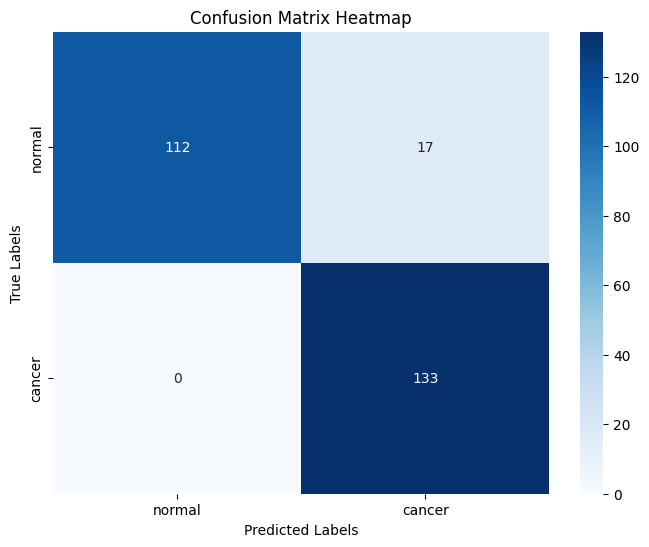

In [155]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
plot_confusion_matrix(true_lables, pred_flat, class_names_step_one)

In [156]:
class_names_step_two = ["benign", "malignant"]

train_path_stage_two = "/Users/sergeiakhmadulin/Documents/Braest Censer/Two steps/Second_step/train"
val_path_stage_two = "/Users/sergeiakhmadulin/Documents/Braest Censer/Two steps/Second_step/val"

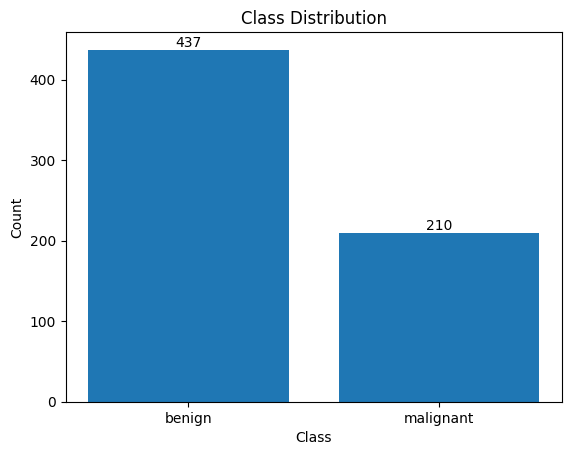

In [175]:
count_and_plot_files(train_path_stage_two, class_names_step_two, stage = 2)

In [183]:
def combine_masks(path, img, orig_name, remove_flag = False, Rectangular = False):
            path_orig_name = os.path.join(path, orig_name)
            first_img = cv2.imread(path_orig_name , cv2.IMREAD_GRAYSCALE)
            
            mask = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
  
            # Apply binary thresholding (convert to a binary mask)
            _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

            new_img = np.zeros_like(first_img)
            # Find contours in the binary mask     
            if Rectangular:
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    
                    x, y, w, h = cv2.boundingRect(contour)
                    if orig_name == img:
                        new_img = cv2.rectangle(new_img, (x, y), (x + w, y + h), (255), -1)  # Green color with thickness 2
                        cv2.imwrite(path_orig_name, new_img)
                    else:
                        first_img = cv2.rectangle(first_img, (x, y), (x + w, y + h), (255), -1)
                        cv2.imwrite(path_orig_name, first_img)
                
            else:
                if orig_name == img:
                    combined_mask = cv2.bitwise_or(new_img,mask)
                    cv2.imwrite(path_orig_name, combined_mask)
                else:
                    combined_mask = cv2.bitwise_or(first_img,mask)
                    cv2.imwrite(path_orig_name, combined_mask)

            if remove_flag:
                os.remove(os.path.join(path, img))

In [186]:
def craete_single_mask_for_file(path, classes, Rectangular,remove_flag = False):
    for class_name in classes:
        full_path = os.path.join(path, "masks")
        files = os.listdir(full_path)
        all_masks = [f for f in files if f.endswith(".png") and "_mask" in f and ".DS_Store" not in f and class_name in f]
        # Filter image files (assuming they are PNGs or another format, adjust as necessary)
        image_files = [f for f in files if f.endswith(".png") and "_mask" in f and ".DS_Store" not in f and "_mask_" not in f and class_name in f]

        # Loop over each image file

        for image_filename in image_files:
    
            mask_files = [f for f in all_masks if image_filename.split(".")[0] in f and "_mask_" in f]
            
            if len(mask_files) > 0:
    
                combine_masks(full_path, image_filename, image_filename, Rectangular = Rectangular)
                for msk_file in mask_files:
                    
                    combine_masks(full_path, msk_file, image_filename, remove_flag = remove_flag, Rectangular = Rectangular)
    
            else:
                combine_masks(full_path, image_filename, image_filename, Rectangular = Rectangular)
    print("Masks are ready")

In [188]:
craete_single_mask_for_file(train_path_stage_two, class_names_step_two, Rectangular = False, remove_flag = True)

Masks are ready


In [53]:
def show_some_images(path, class_name, augmented = False, name_table = "Original"):
    """
    Function that shows 4 images for given path and class name

    Parameters:
    path: location for folders of classes with images
    class_name: variable of given names of classes
    augmented: flag of augmentation
    name_table: table name that indicates wather images are original or augmentated

    Outputs:
    Nothing, just shows images
    """
    full_path = path + class_name
    files = os.listdir(full_path)
    files = [file for file in files if '_mask' not in os.path.basename(file)]

    if augmented:
        files = [file for file in files if 'augmented_image_' in os.path.basename(file)]


    fig, axes = plt.subplots(1, 4, figsize=(14, 5))
    fig.suptitle(f'{name_table} images of class: {class_name}', fontsize=16)

    for i, image in enumerate(files[:4]):
        img = load_img(full_path + "/" + image)
        axes[i].imshow(img)
        axes[i].set_title(f'Example {class_name} {i}')
    
    plt.show()

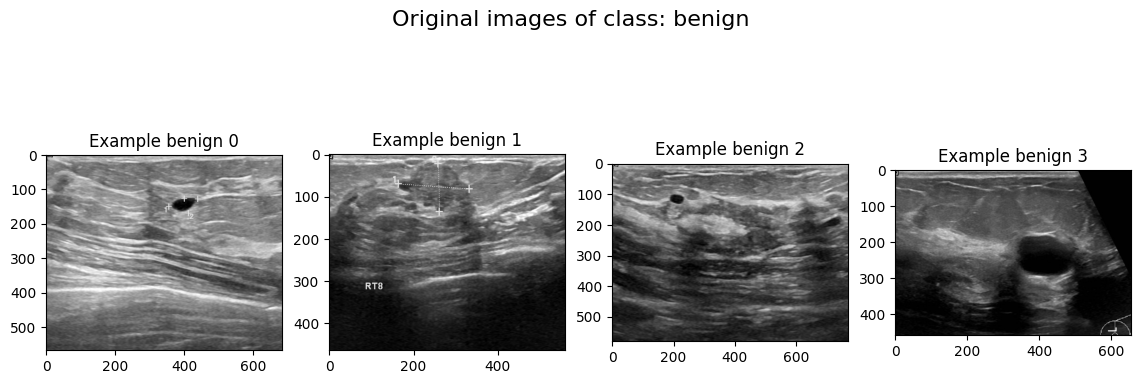

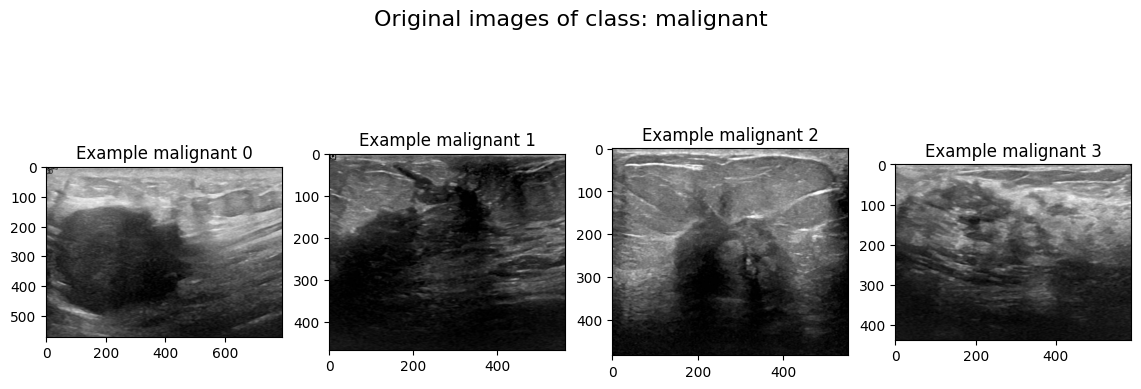

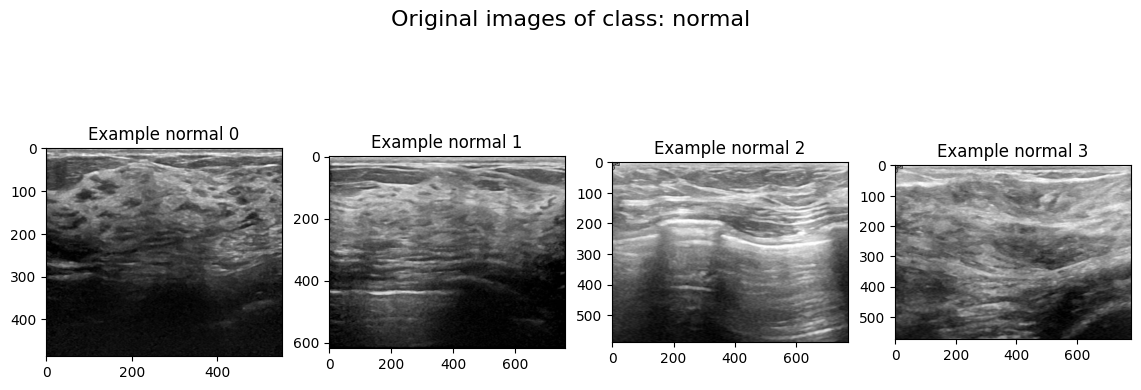

In [54]:
for i in class_names:
    show_some_images(train_path,i)

Found 14694 files belonging to 3 classes.
Found 2044 files belonging to 3 classes.


In [153]:
def run_training(model,danse_neurons,dropout,learning_rate,epochs,patience):
    # Build the model
    model = models.Sequential([
        model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(danse_neurons, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(3, activation='softmax')  # Output layer for 3 classes
    ])
    
    # Compile the model with sparse_categorical_crossentropy for integer-encoded labels
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        verbose=1,
        callbacks = [EarlyStoppingCallback(patience=patience),checkpoint,reduce_lr]
    )

In [154]:
run_training(base_model,1028,0.5,0.001,5,3)

Epoch 1/5
New best accuracy: 0.6477

Epoch 1: val_accuracy improved from -inf to 0.64775, saving model to best_model_EfficientNetB0_base_0.keras
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 110s 69ms/step - accuracy: 0.6350 - loss: 1.0471 - val_accuracy: 0.6477 - val_loss: 0.9338 - learning_rate: 0.0010
Epoch 2/5
New best accuracy: 0.7255

Epoch 2: val_accuracy improved from 0.64775 to 0.72554, saving model to best_model_EfficientNetB0_base_0.keras
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 93s 63ms/step - accuracy: 0.7065 - loss: 0.8914 - val_accuracy: 0.7255 - val_loss: 0.8093 - learning_rate: 0.0010
Epoch 3/5
No improvement in epoch 3. Waiting 1/3...

Epoch 3: val_accuracy did not improve from 0.72554
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 93s 63ms/step - accuracy: 0.7069 - loss: 0.9382 - val_accuracy: 0.7177 - val_loss: 0.9310 - learning_rate: 0.0010
Epoch 4/5
No improvement in epoch 4. Waiting 2/3...

Epoch 4: val_accuracy did not improve from 0.72554

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002000

In [156]:
run_training(base_model,1028,0.5,0.001,5,3)

Epoch 1/5
New best accuracy: 0.7011

Epoch 1: val_accuracy did not improve from 0.72554
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 369s 228ms/step - accuracy: 0.7048 - loss: 0.7937 - val_accuracy: 0.7011 - val_loss: 1.1738 - learning_rate: 0.0010
Epoch 2/5
No improvement in epoch 2. Waiting 1/3...

Epoch 2: val_accuracy did not improve from 0.72554
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 329s 224ms/step - accuracy: 0.7389 - loss: 0.7535 - val_accuracy: 0.6756 - val_loss: 1.0345 - learning_rate: 0.0010
Epoch 3/5
No improvement in epoch 3. Waiting 2/3...

Epoch 3: val_accuracy did not improve from 0.72554
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 330s 225ms/step - accuracy: 0.7504 - loss: 0.7899 - val_accuracy: 0.7094 - val_loss: 0.9160 - learning_rate: 0.0010
Epoch 4/5
No improvement in epoch 4. Waiting 3/3...
Early stopping triggered!

Epoch 4: val_accuracy did not improve from 0.72554
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 328s 223ms/step - accuracy: 0.7659 - loss: 0.7521 - val_accuracy: 0.6747 - val_loss: 1.4859 - learning